In [ ]:
#!/usr/bin/env python3
from scapy.all import rdpcap, wrpcap, IP, TCP, UDP
from pathlib import Path
from collections import Counter
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt

# ------------ Config ------------
input_pcap = Path("../../raw_pcaps/browsing.pcap")
output_uplink_pcap   = Path("../../pcaps/pcap/uplink_pcap/browsing_uplink.pcap")     
output_downlink_pcap = Path("../../pcaps/pcap/downlink_pcap/browsing_downlink.pcap")  

# CSVs (same directory as pcaps)
output_uplink_csv    = Path("../../pcaps/csv/uplink_csv/browsing_uplink.csv")  
output_downlink_csv  = Path("../../pcaps/csv/downlink_csv/browsing_downlink.csv")  

# Map original IPs to rewritten addresses
ip_map = {
    "192.168.86.29": "10.0.0.0",
    "130.132.2.16": "10.0.0.1",


}
TOP_N = 10
# --------------------------------

# Ensure output dirs exist
output_uplink_pcap.parent.mkdir(parents=True, exist_ok=True)
output_downlink_pcap.parent.mkdir(parents=True, exist_ok=True)

# Read packets
packets = rdpcap(str(input_pcap))

# Pre-filter stats
ip_counter = Counter()
for pkt in packets:
    if pkt.haslayer(IP) and (pkt.haslayer(TCP) or pkt.haslayer(UDP)):
        ip_counter.update([pkt[IP].src, pkt[IP].dst])

print("Top IPs (TCP/UDP IPv4) before filtering:")
for ip, cnt in ip_counter.most_common(TOP_N):
    print(f"{ip:>15}  {cnt}")


Top IPs (TCP/UDP IPv4) before filtering:
  192.168.86.29  86065
   130.132.2.16  85306
   192.168.86.1  838
239.255.255.250  128
    224.0.0.251  75
  192.168.86.28  40
        0.0.0.0  22
255.255.255.255  22
  192.168.86.27  8
 192.168.86.255  2


In [ ]:
allowed = set(ip_map.keys())   # Keep only packets where BOTH endpoints are in allowlist, then rewrite
kept = []
for pkt in packets:
    if not (pkt.haslayer(IP) and (pkt.haslayer(TCP) or pkt.haslayer(UDP))):
        continue
    src, dst = pkt[IP].src, pkt[IP].dst
    if src in allowed and dst in allowed:
        # Rewrite
        new_src = ip_map[src]
        new_dst = ip_map[dst]
        if new_src != src or new_dst != dst:
            pkt[IP].src = new_src
            pkt[IP].dst = new_dst
            # Recompute checksums/lengths
            if pkt.haslayer(TCP):
                try: del pkt[TCP].chksum
                except: pass
            if pkt.haslayer(UDP):
                try: del pkt[UDP].chksum
                except: pass
            try: del pkt[IP].chksum
            except: pass
            try: del pkt[IP].len
            except: pass
        kept.append(pkt)

print(f"\nTotal input packets: {len(packets)}")
print(f"Kept (both endpoints mapped): {len(kept)}")
print(f"Dropped: {len(packets) - len(kept)}")




Total input packets: 86392
Kept (both endpoints mapped): 85306
Dropped: 1086


In [13]:
# Split into uplink/downlink after rewrite
uplink = []    # 10.0.0.0 -> 10.0.0.1
downlink = []  # 10.0.0.1 -> 10.0.0.0
for pkt in kept:
    s, d = pkt[IP].src, pkt[IP].dst
    if s == "10.0.0.0" and d == "10.0.0.1":
        uplink.append(pkt)
    elif s == "10.0.0.1" and d == "10.0.0.0":
        downlink.append(pkt)

# Save pcaps
if uplink:
    wrpcap(str(output_uplink_pcap), uplink)
if downlink:
    wrpcap(str(output_downlink_pcap), downlink)

print(f"\nUplink packets (10.0.0.0 -> 10.0.0.1): {len(uplink)}")
print(f"Downlink packets (10.0.0.1 -> 10.0.0.0): {len(downlink)}")
if uplink:
    print(f"Saved uplink pcap to:   {output_uplink_pcap}")
if downlink:
    print(f"Saved downlink pcap to: {output_downlink_pcap}")

# ---- Relative time baseline (first kept packet => t=0.000000) ----
baseline_ts = min(getattr(p, "time", 0.0) for p in kept) if kept else 0.0

# Write CSVs (time, source, destination, packet_length) with relative time
def write_csv(path: Path, pkts, baseline: float):
    # Always create the CSV with header
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["time", "source", "destination", "packet_length"])
        if not pkts:
            return
        for p in pkts:
            ts_abs = getattr(p, "time", 0.0)
            ts_rel = ts_abs - baseline  # start from 0.0
            src = p[IP].src
            dst = p[IP].dst
            try:
                plen = len(bytes(p))  # full serialized packet size
            except Exception:
                plen = getattr(p[IP], "len", 0)
            w.writerow([f"{ts_rel:.6f}", src, dst, int(plen) if plen is not None else ""])

# Save CSVs alongside pcaps (both use the same baseline so timelines align)
write_csv(output_uplink_csv, uplink, baseline_ts)
write_csv(output_downlink_csv, downlink, baseline_ts)

if uplink:
    print(f"Saved uplink CSV to:   {output_uplink_csv}")
if downlink:
    print(f"Saved downlink CSV to: {output_downlink_csv}")

# Optional: quick sanity check of top IPs after rewrite
post_counter = Counter()
for pkt in kept:
    post_counter.update([pkt[IP].src, pkt[IP].dst])
print("\nTop IPs after filtering + rewrite:")
for ip, cnt in post_counter.most_common(TOP_N):
    print(f"{ip:>15}  {cnt}")


Uplink packets (10.0.0.0 -> 10.0.0.1): 25857
Downlink packets (10.0.0.1 -> 10.0.0.0): 59449
Saved uplink pcap to:   ..\..\clean_pcaps\pcap\uplink_pcap\browsing_uplink.pcap
Saved downlink pcap to: ..\..\clean_pcaps\pcap\downlink_pcap\browsing_downlink.pcap
Saved uplink CSV to:   ..\..\clean_pcaps\csv\uplink_csv\browsing_uplink.csv
Saved downlink CSV to: ..\..\clean_pcaps\csv\downlink_csv\browsing_downlink.csv

Top IPs after filtering + rewrite:
       10.0.0.0  85306
       10.0.0.1  85306


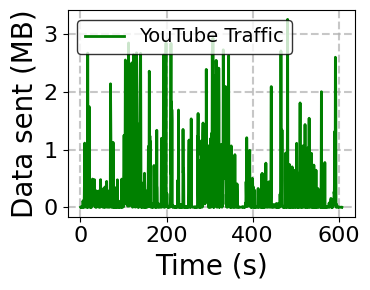

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Config ----------
uplink_csv    = Path("../../clean_pcaps/csv/uplink_csv/mixed_traffic_uplink.csv")
downlink_csv  = Path("../../clean_pcaps/csv/downlink_csv/mixed_traffic_downlink.csv")
WINDOW = 0.5  # seconds for aggregation bins
# ----------------------------

def load_csv(path: Path):
    df = pd.read_csv(path)
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["packet_length"] = pd.to_numeric(df["packet_length"], errors="coerce")
    df = df.dropna(subset=["time", "packet_length"]).copy()
    df = df.sort_values("time").reset_index(drop=True)
    return df

def aggregate_bytes(df, window=0.5, base_time=None):
    """Aggregate bytes per fixed time window; returns columns: bin_start_s, bytes"""
    if df.empty:
        return pd.DataFrame(columns=["bin_start_s", "bytes"])
    d = df.copy()
    if base_time is None:
        base_time = float(d["time"].iloc[0])
    d["t_rel"] = d["time"] - float(base_time)
    d["bin_start_s"] = (np.floor(d["t_rel"] / window) * window).round(6)
    agg = (
        d.groupby("bin_start_s", as_index=False)["packet_length"]
         .sum()
         .rename(columns={"packet_length": "bytes"})
    )
    return agg

# ---------- Main ----------
df_up = load_csv(uplink_csv) if uplink_csv.exists() else pd.DataFrame(columns=["time", "packet_length"])
df_dn = load_csv(downlink_csv) if downlink_csv.exists() else pd.DataFrame(columns=["time", "packet_length"])

# Align to a common origin so UL/DL bins line up
valid_starts = []
if not df_up.empty: valid_starts.append(float(df_up["time"].iloc[0]))
if not df_dn.empty: valid_starts.append(float(df_dn["time"].iloc[0]))
base_time = min(valid_starts) if valid_starts else 0.0

agg_up = aggregate_bytes(df_up, window=WINDOW, base_time=base_time)
agg_dn = aggregate_bytes(df_dn, window=WINDOW, base_time=base_time)

# Prepare for merge (rename bytes columns)
agg_up = agg_up.rename(columns={"bytes": "bytes_ul"})
agg_dn = agg_dn.rename(columns={"bytes": "bytes_dl"})

# Merge on bins and compute total
combined = pd.merge(agg_up, agg_dn, on="bin_start_s", how="outer").sort_values("bin_start_s")
for col in ["bytes_ul", "bytes_dl"]:
    if col not in combined.columns:
        combined[col] = 0.0
combined[["bytes_ul", "bytes_dl"]] = combined[["bytes_ul", "bytes_dl"]].fillna(0)
combined["bytes_total"] = combined["bytes_ul"] + combined["bytes_dl"]

if not combined.empty:
    x = combined["bin_start_s"] + WINDOW / 2.0
    y_mb = combined["bytes_total"] / (1024 * 1024)   # convert bytes → MB

    plt.figure(figsize=(4, 3))
    plt.plot(x, y_mb, linewidth=2, color="green", label="YouTube Traffic")
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Data sent (MB)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, which="both", linestyle="--", linewidth=1.5, alpha=0.7)
    plt.legend(
        loc="upper left",
        fontsize=14,
        frameon=True,
        facecolor="white",
        edgecolor="black"
    )
    plt.tight_layout()

    # Save at 400 dpi
    plt.savefig("youtube_traffic.jpg", dpi=400, bbox_inches="tight")

    plt.show()


